# 7주차 의사결정나무(Decision Tree)

## 1. 라이브러리 불러오기

In [0]:
# Python2, Python3 호환성
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# 데이터 전처리
import numpy as np
import pandas as pd

#데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import Source
from IPython.display import Image

# 모델 구축 및 성능 평가
from sklearn.preprocessing import StandardScaler # 평균이 0과 표준편차가 1이 되도록 변환.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")

## 2. 데이터 불러오기

In [29]:
url = 'https://raw.githubusercontent.com/dmqa/2019-Machine-Learning-Course/master/3%EC%9D%BC%EC%B0%A8_%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4%EB%B0%8F%EC%95%99%EC%83%81%EB%B8%94/%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/BreastCancerWisconsin.csv'

data = pd.read_csv(url)
display(data.head())

X = data.drop(['diagnosis'], axis=1)
X = X.iloc[:, :10]
y = data['diagnosis']

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


### [TIP1] 분석에 앞서 Class distribution 확인 
### Class 불균형 발생시, 일반적인 모델링으로는 우수한 성능을 내기 어려움 

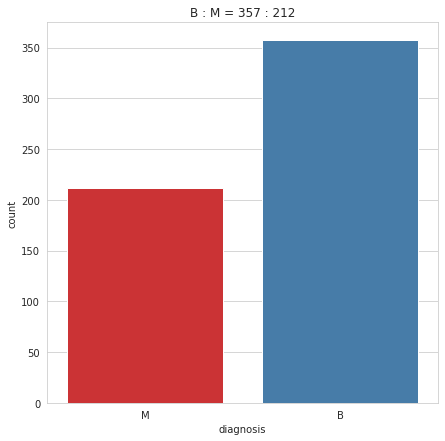

In [30]:
# Check class label distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sns.countplot(y, palette='Set1', ax=ax)
ax.set_title("B : M = {} : {}".format(*y.value_counts()))
plt.show()

In [31]:
print('클래스별 데이터 개수')
display(y.value_counts())

클래스별 데이터 개수


B    357
M    212
Name: diagnosis, dtype: int64

### 학습을 위해 Train / Test 데이터 분리

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=1/10,
                                                    stratify=y,
                                                    random_state=20191108)

### Train 데이터에 대해 
### 1) scaling을 통한 변수 범위 일치

In [0]:
# 스케일링은 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시킴
# https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/ - 데이터 사이언스 스쿨
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2) validation set 분리 - parameter 튜닝 목적

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=1/9,
                                                      stratify=y_train,
                                                      random_state=20191108)

## 3. Decision Tree 모델 구축
### 풀고자 하는 문제의 종류에 따라 다른 criterion 사용이 필요함
#### 분류문제 : gini index 사용
#### 회귀문제 : mse

In [60]:
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### 예측 수행(train / valid)
#### 데이터에 대한 정확도
- 참고 URL : https://frhyme.github.io/machine-learning/clf_%ED%8F%89%EA%B0%80%ED%95%98%EA%B8%B0/
- confusion_matrix : Positive/Negative를 예측
- accuracy_score : 정확하게 예측 된 레이블 / 전체 레이블 수 

In [64]:
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)

# 예측에 대한 결과
display( pd.DataFrame(confusion_matrix(y_train, y_train_pred), columns=[0,1], index=[0,1]) )
print('- Accuracy (Train)      : {:.4}'.format(accuracy_score(y_train, y_train_pred)))

display( pd.DataFrame(confusion_matrix(y_valid, y_valid_pred), columns=[0,1], index=[0,1]) )
print('- Accuracy (Validation) : {:.4}'.format(accuracy_score(y_valid, y_valid_pred)))

,0,1
0,285,0
1,0,170


- Accuracy (Train)      : 1.0


,0,1
0,34,2
1,3,18


- Accuracy (Validation) : 0.9123


In [118]:
type(pd.Series(y_train_pred))
pd.Series(y_train_pred)

0      M
1      B
2      B
3      B
4      B
      ..
450    B
451    B
452    M
453    M
454    B
Length: 455, dtype: object

In [122]:
type(y_train)
y_train

254    M
349    B
411    B
485    B
526    B
      ..
374    B
371    B
317    M
53     M
418    B
Name: diagnosis, Length: 455, dtype: object

## Decision Tree의 장점은 데이터 분할 기준에 따른 규칙 생성이 가능
### 규칙의 시각화

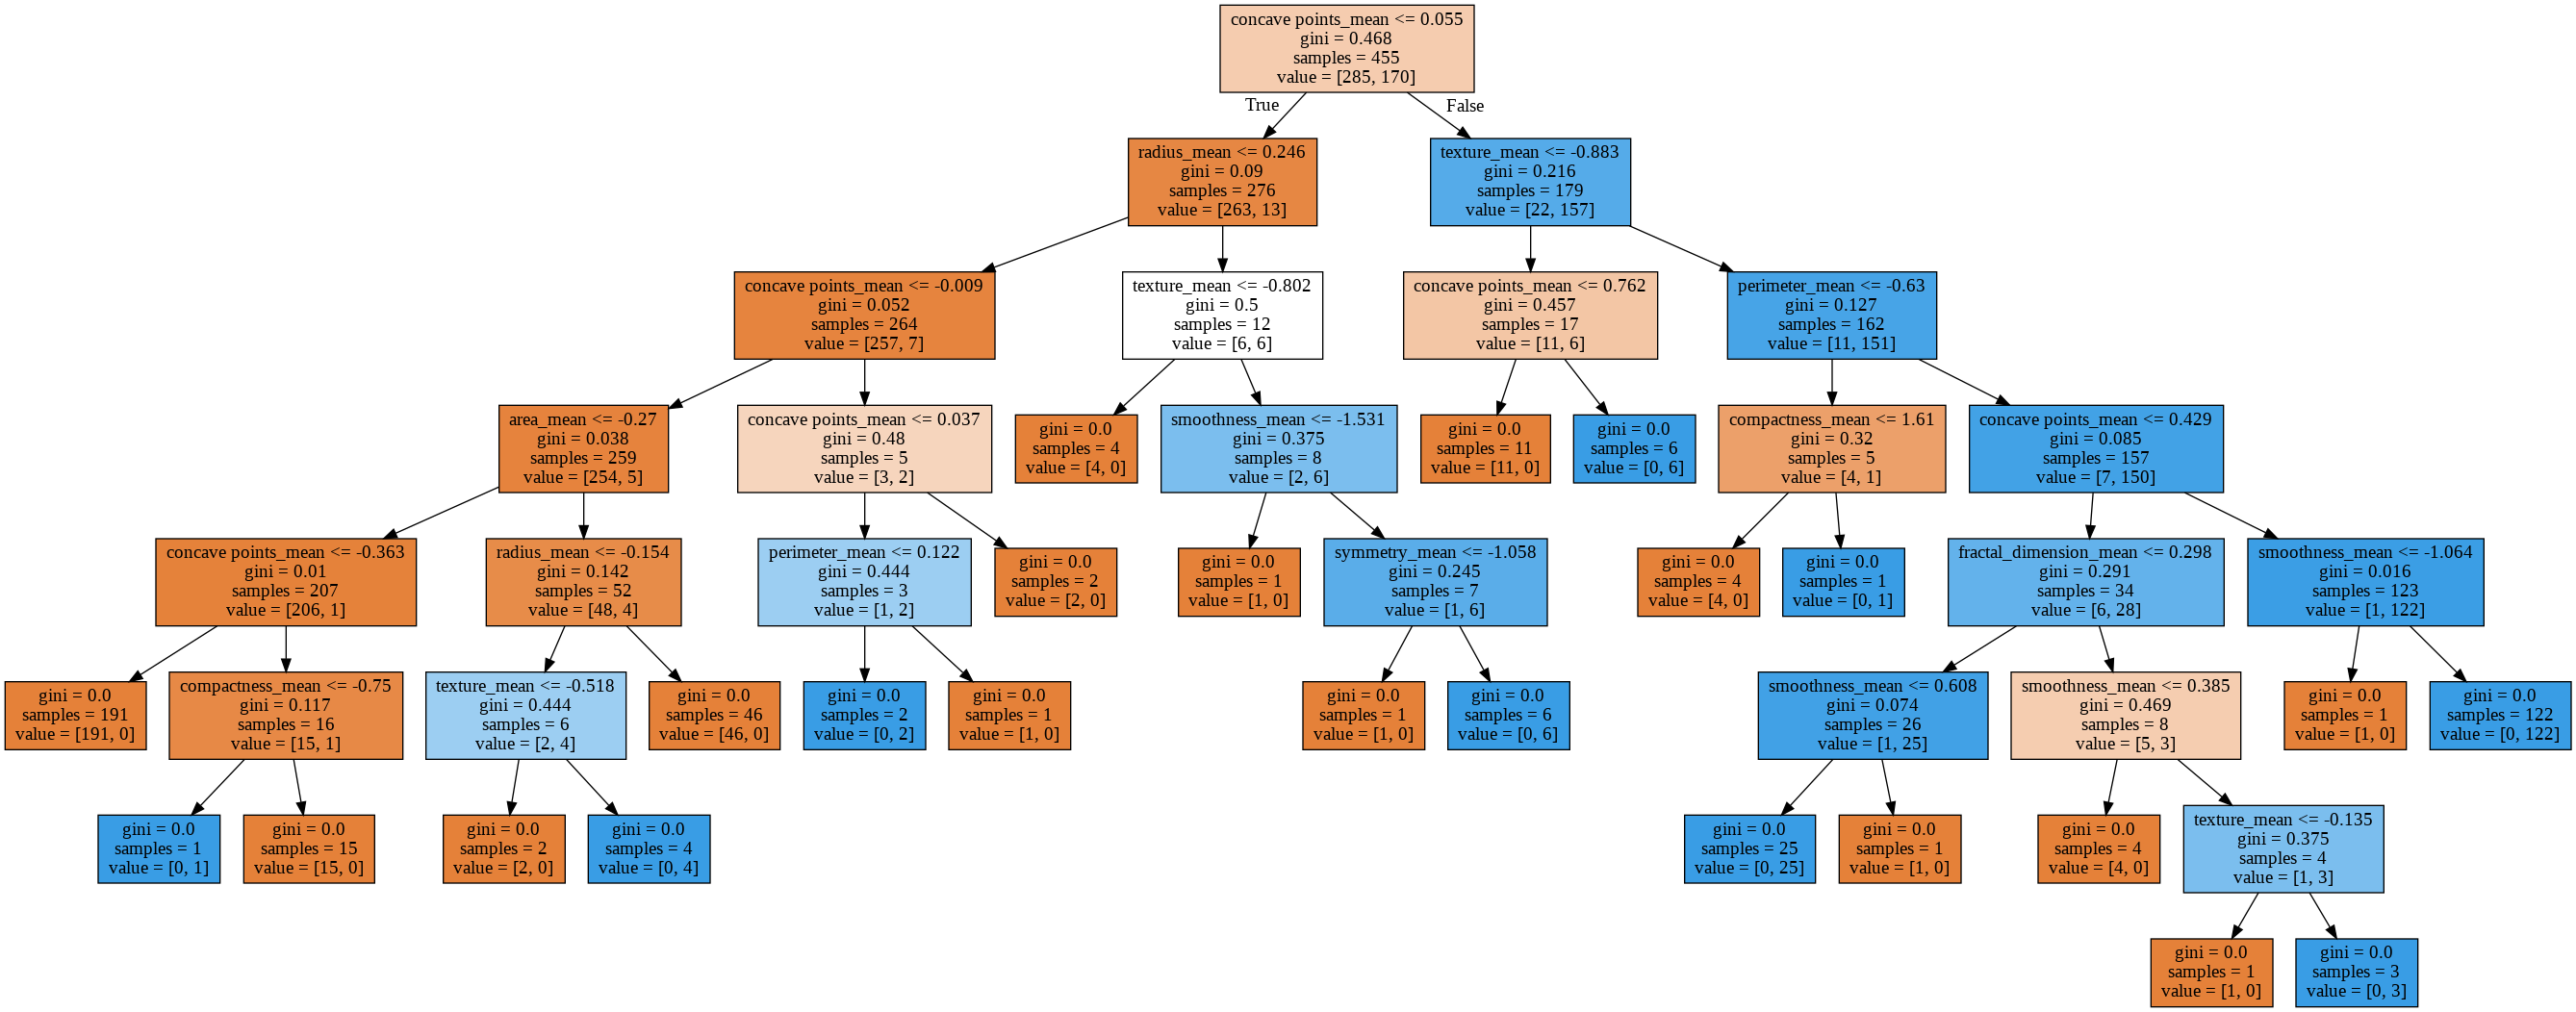

In [37]:
# https://datascienceschool.net/view-notebook/16c28c8c192147bfb3d4059474209e0a/ - 데이터 사이언스 스쿨
graph = Source(export_graphviz(clf_dt,
                               out_file=None,
                               feature_names=X.columns,
                               filled=True,
                               leaves_parallel=False))
Image(graph.pipe(format='png'))

### 데이터에 적합한 모델을 구축하기 위해 parameter 튜닝이 필요함 
#### DT에는 모델의 depth를 적정하게 설정하는 것이 중요함 (overfitting 가능성 최소화)
#### https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/ - 분류성능평가

In [49]:
best_depths = 0
best_accurancy = 0

max_depths = list(range(1, 10, 1))
validation_accs = []
validation_f1 = []
dt_models = []

for max_depth in max_depths:
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    clf_dt.fit(X_train, y_train)
    dt_models.append(clf_dt)
    y_valid_pred = clf_dt.predict(X_valid)
    validation_accs.append(accuracy_score(y_valid, y_valid_pred))
    validation_f1.append(f1_score(y_valid, y_valid_pred, pos_label='M'))

    print('depth : {}, accurancy : {}, f1-score : {}'.format(max_depth,accuracy_score(y_valid, y_valid_pred), f1_score(y_valid, y_valid_pred, pos_label='M')))

    if (best_accurancy < accuracy_score(y_valid, y_valid_pred)): # 최적의 accuracy_score 구하기
      best_accurancy = accuracy_score(y_valid, y_valid_pred)
      best_depths = max_depth

print('최적의 depth :',best_depths)

depth : 1, accurancy : 0.8421052631578947, f1-score : 0.7906976744186046
depth : 2, accurancy : 0.8947368421052632, f1-score : 0.8500000000000001
depth : 3, accurancy : 0.9473684210526315, f1-score : 0.9302325581395349
depth : 4, accurancy : 0.9298245614035088, f1-score : 0.9047619047619048
depth : 5, accurancy : 0.8947368421052632, f1-score : 0.8500000000000001
depth : 6, accurancy : 0.9122807017543859, f1-score : 0.8837209302325582
depth : 7, accurancy : 0.8947368421052632, f1-score : 0.8500000000000001
depth : 8, accurancy : 0.8947368421052632, f1-score : 0.8500000000000001
depth : 9, accurancy : 0.9122807017543859, f1-score : 0.8780487804878048
최적의 depth : 3


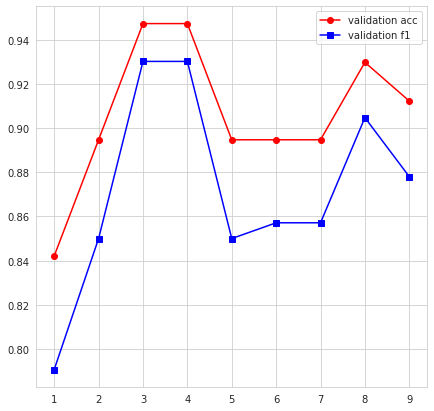

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(max_depths, validation_accs, color='red', marker='o', label='validation acc')
ax.plot(max_depths, validation_f1, color='blue', marker='s', label='validation f1')
ax.legend(loc='best')
plt.show(fig)

### Validation set에 대해 우수한 성능을 보였던 depth는 3 또는 4
#### 우리는 depth를 3,4로 설정할때 test set에 대해서도 상대적으로 우수한 성능을 보일것이라 기대할 수 있음

In [50]:
best_model_idx, best_model_f1 = max(enumerate(validation_f1), key=lambda p: p[1])
y_test_pred = dt_models[best_model_idx].predict(X_test)
print('- Accuracy (Test) : {:.4}'.format(accuracy_score(y_test, y_test_pred)))
print('- F1 score (Test) : {:.4}'.format(f1_score(y_test, y_test_pred, pos_label='M')))

- Accuracy (Test) : 0.9474
- F1 score (Test) : 0.9268


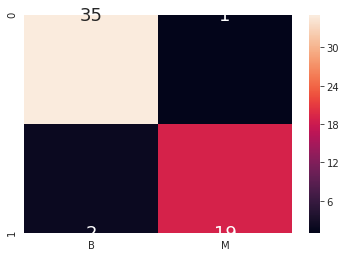

In [51]:
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test = pd.DataFrame(cm_test, columns=['B', 'M'])
sns.heatmap(data=cm_test, annot=True, annot_kws={'size': 18})

### Best Model에 대한 규칙 (시각화)

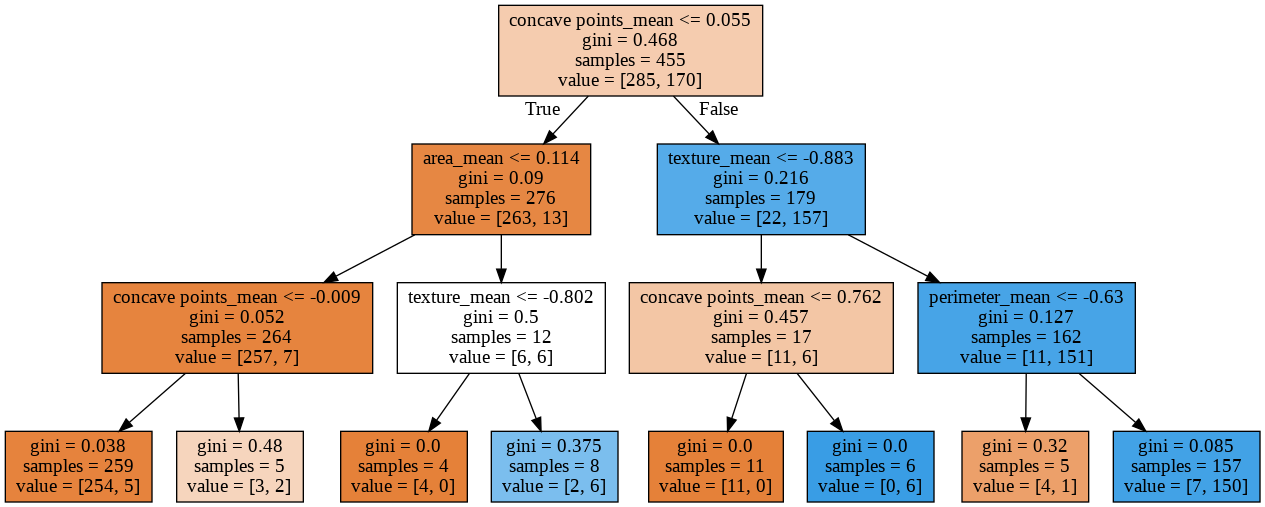

In [52]:
graph = Source(export_graphviz(dt_models[best_model_idx],
                               out_file=None,
                               feature_names=X.columns,
                               filled=True,
                               leaves_parallel=True))
png_bytes = graph.pipe(format='png')
Image(png_bytes)


In [0]:
with open('dt_best.png', 'wb') as f:
    f.write(png_bytes)

### DT(Decision Tree)는 규칙을 시각적으로 제공이 가능할 뿐만 아니라
### 각 변수의 중요도를 제공 (Linear regression의 coefficient와 유사한 개념)

In [54]:
imp = dt_models[best_model_idx].feature_importances_
imp = pd.DataFrame([X.columns, imp]).T
imp.columns = ['variables', 'importance']
print(imp[imp['importance'] != 0])

             variables importance
1         texture_mean  0.0728799
2       perimeter_mean  0.0302563
3            area_mean  0.0281565
7  concave points_mean   0.868707


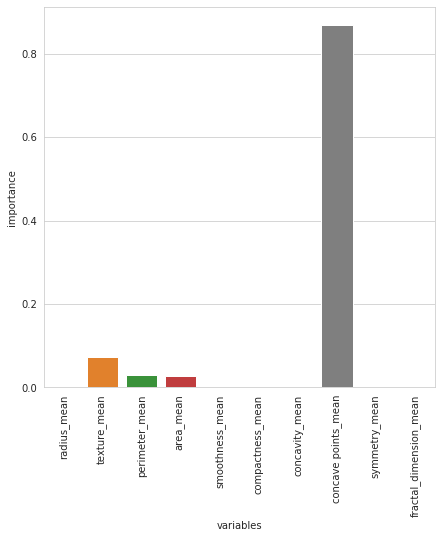

In [55]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='variables', y='importance', data=imp, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show(fig)

### 변수의 중요가 높다 = 분류(또는 회귀)를 수행하는데 critical한 역활을 한다
### 중요도 순위가 높은 2개의 변수를 사용하여 2차원 시각화를 수행
### 2개의 변수 (concave_points_mean, texture_mean)을 사용하여도 2개의 class가 어느정도 분류가 됨을 확인 가능

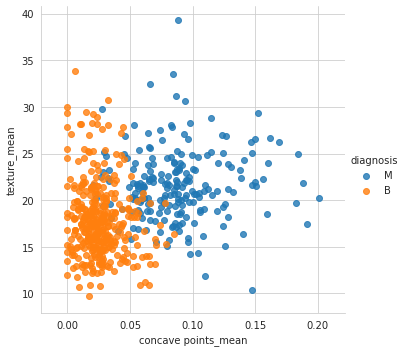

In [56]:
sns.lmplot(x='concave points_mean', y='texture_mean',
           hue='diagnosis', data=data, fit_reg=False)